In [1]:
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Source: Ontario Open Data Confirmed positive cases of COVID-19 in Ontario dataset
# https://data.ontario.ca/dataset/confirmed-positive-cases-of-covid-19-in-ontario 

import urllib
url = 'https://data.ontario.ca/api/3/action/datastore_search?resource_id=455fd63b-603d-4608-8216-7d8647f43350&limit=1000000'
data_original = pd.DataFrame(requests.get(url).json()["result"]["records"])
data_original.shape
# 416995 records as of Sun April 18
# 421442 records as of Mon April 19

(424911, 19)

See https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/a2ea0536-1eae-4a17-aa04-e5a1ab89ca9a/download/conposcovidloc_data_dictionary.xlsx for Data Dictionary 

In [2]:
data_raw = data_original.copy()

In [3]:
data_raw.columns

Index(['_id', 'Row_ID', 'Accurate_Episode_Date', 'Case_Reported_Date',
       'Test_Reported_Date', 'Specimen_Date', 'Age_Group', 'Client_Gender',
       'Case_AcquisitionInfo', 'Outcome1', 'Outbreak_Related',
       'Reporting_PHU_ID', 'Reporting_PHU', 'Reporting_PHU_Address',
       'Reporting_PHU_City', 'Reporting_PHU_Postal_Code',
       'Reporting_PHU_Website', 'Reporting_PHU_Latitude',
       'Reporting_PHU_Longitude'],
      dtype='object')

In [4]:
data_raw['date'] = pd.to_datetime(data_raw.Accurate_Episode_Date)

In [5]:
data_raw['age'] = data_raw.Age_Group.apply(lambda x: '0-19' if x=='<20' else x)

In [6]:
data = data_raw[['date','age','Client_Gender', 'Outcome1']]\
               .rename(columns={'Client Gender':'sex', 'Outcome1':'outcome'})

In [7]:
data['fatal']=data.outcome.apply(lambda x:True if x=='Fatal' else False)
data

,date,age,Client_Gender,outcome,fatal
0,2020-05-22,40s,MALE,Resolved,False
1,2020-05-24,20s,FEMALE,Resolved,False
2,2020-04-09,60s,MALE,Fatal,True
3,2020-04-06,50s,FEMALE,Resolved,False
4,2020-04-13,20s,FEMALE,Resolved,False
...,...,...,...,...,...
424906,2021-03-03,50s,MALE,Resolved,False
424907,2021-03-01,50s,MALE,Resolved,False
424908,2021-03-01,50s,MALE,Resolved,False
424909,2021-02-23,70s,MALE,Resolved,False


Compare 2 periods: January 13-26, 2021 and March 10-23, 2021.

Cut-off date March 23 chosen because expect substantially all deaths to be reported by now.  

Per https://doi.org/10.1016/S0140-6736(20)30566-3, Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study, The Lancet, March 11, 2020:

>The median time from illness onset (ie, before admission) to discharge was 22·0 days (IQR 18·0–25·0), whereas the median time to death was 18·5 days (15·0–22·0; table 2).

In [8]:
jan = data[(data.date>=np.datetime64('2021-01-13'))&(data.date<=np.datetime64('2021-01-26'))]
mar = data[(data.date>=np.datetime64('2021-03-10'))&(data.date<=np.datetime64('2021-03-23'))]
jan_date_range_str = 'Jan 13-26, 2021'
mar_date_range_str = 'Mar 10-23, 2021'

In [9]:
age_bands = pd.Series(data.age.unique()).sort_values()[:-1].to_list() # -1 to remove UNKNOWN category
age_bands

['0-19', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90+']

In [10]:
jan_by_age = jan.groupby('age').agg({'date':'count', 'fatal':'sum'}).drop('UNKNOWN')\
               .rename(columns={'date':'num_cases'})
mar_by_age = mar.groupby('age').agg({'date':'count', 'fatal':'sum'}).drop('UNKNOWN')\
               .rename(columns={'date':'num_cases'})          

In [11]:
jan_by_age['pct_fatal'] = 100 * jan_by_age.fatal / jan_by_age.num_cases
mar_by_age['pct_fatal'] = 100 * mar_by_age.fatal / mar_by_age.num_cases
jan_by_age

,num_cases,fatal,pct_fatal
age,,,
0-19,3779,0,0.000000
20s,5879,2,0.034019
30s,4519,4,0.088515
40s,4073,5,0.122760
50s,4416,27,0.611413
60s,2762,39,1.412020
70s,1487,105,7.061197
80s,1227,183,14.914425
90+,662,151,22.809668


In [12]:
mar_by_age

,num_cases,fatal,pct_fatal
age,,,
0-19,5060,0,0.000000
20s,5091,4,0.078570
30s,4209,1,0.023759
40s,3756,9,0.239617
50s,3414,10,0.292912
60s,2140,35,1.635514
70s,1082,51,4.713494
80s,473,62,13.107822
90+,130,27,20.769231


In [13]:
# mortality rates per 1000 in Canada for 2019 from https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1310071001
mort_rates_per_thou = np.array([['<1', 4.4],['1-4', 0.2],['5-9', 0.1],['10-14', 0.1],['15-19', 0.3],['20-24', 0.5],['25-29', 0.7],
                                ['30-34', 0.8],['35-39', 0.9],['40-44', 1.2],['45-49', 1.8],['50-54', 2.8],['55-59', 4.5],['60-64', 7.0],
                                ['65-69', 10.8],['70-74', 17.1],['75-79', 27.9],['80-84', 49.1],['85-89', 88.8],['90+', 188.4]])
mort_rates = pd.DataFrame(mort_rates_per_thou, columns=['age','rate_per_thou']).set_index('age')
mort_rates['pct_rate'] = mort_rates.rate_per_thou.apply(lambda x: float(x)/10)
mort_rates['age_band_idx'] = pd.Series([0,0,0,0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8], index=mort_rates.index)
mort_pct_rates = mort_rates.groupby('age_band_idx').mean()
mort_pct_rates.set_index(mort_pct_rates.reset_index().age_band_idx.apply(lambda x: age_bands[x]), inplace=True)
mort_pct_rates

,pct_rate
age_band_idx,
0-19,0.102
20s,0.060
30s,0.085
40s,0.150
50s,0.365
60s,0.890
70s,2.250
80s,6.895
90+,18.840


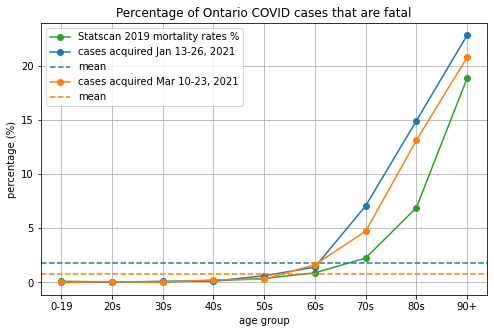

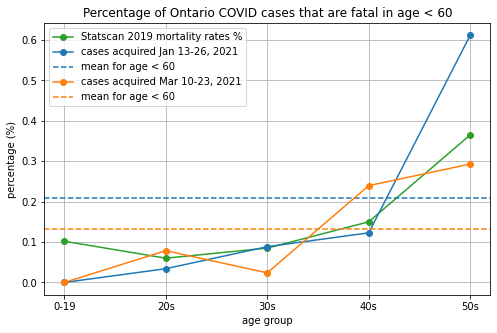

In [14]:
plt.figure(figsize=(8,5))
plt.plot(mort_pct_rates, marker='o', label='Statscan 2019 mortality rates %', color='tab:green')
plt.plot(jan_by_age.pct_fatal, marker='o', label='cases acquired '+jan_date_range_str, color='tab:blue')
plt.axhline(100*jan_by_age.sum().fatal/jan_by_age.sum().num_cases, color='tab:blue', linestyle='--', 
            label='mean')
plt.plot(mar_by_age.pct_fatal, marker='o', label='cases acquired '+mar_date_range_str, color='tab:orange')
plt.axhline(100*mar_by_age.sum().fatal/mar_by_age.sum().num_cases, color='tab:orange', linestyle='--', 
            label='mean')
plt.title('Percentage of Ontario COVID cases that are fatal')
plt.xlabel('age group')
plt.ylabel('percentage (%)')
plt.grid()
plt.legend()
plt.show();

plt.figure(figsize=(8,5))
plt.plot(mort_pct_rates.loc[age_bands[0:5]], marker='o', label='Statscan 2019 mortality rates %', color='tab:green')
plt.plot(jan_by_age.loc[age_bands[0:5]].pct_fatal, marker='o', label='cases acquired '+jan_date_range_str, color='tab:blue')
plt.axhline(y=100*jan_by_age.loc[age_bands[0:5]].sum().fatal/jan_by_age.loc[age_bands[0:4]].sum().num_cases, 
            color='tab:blue', linestyle='--', label='mean for age < 60')
plt.plot(mar_by_age.loc[age_bands[0:5]].pct_fatal, marker='o', label='cases acquired '+mar_date_range_str, color='tab:orange')
plt.axhline(y=100*mar_by_age.loc[age_bands[0:5]].sum().fatal/mar_by_age.loc[age_bands[0:4]].sum().num_cases, 
            color='tab:orange', linestyle='--', label='mean for age < 60')
plt.title('Percentage of Ontario COVID cases that are fatal in age < 60')
plt.xlabel('age group')
plt.ylabel('percentage (%)')
plt.grid()
plt.legend()
plt.show();